In [69]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pickle
%matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

In [2]:
df = pd.read_csv("./datasets/first 1 million.csv")

In [3]:
df.head()

,categories,text
0,hep-ph,calcul prompt diphoton product cross section t...
1,math.CO cs.CG,sparsiti certifi graph decomposit describ new ...
2,physics.gen-ph,evolut earth moon system base dark matter fiel...
3,math.CO,determin stirl cycl number count unlabel acycl...
4,math.CA math.FA,dyadic lambda alpha lambda alpha paper show co...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   categories  999999 non-null  object
 1   text        999999 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [5]:
df['categories'] = df['categories'].str.split()

In [6]:
df.head()

,categories,text
0,[hep-ph],calcul prompt diphoton product cross section t...
1,"[math.CO, cs.CG]",sparsiti certifi graph decomposit describ new ...
2,[physics.gen-ph],evolut earth moon system base dark matter fiel...
3,[math.CO],determin stirl cycl number count unlabel acycl...
4,"[math.CA, math.FA]",dyadic lambda alpha lambda alpha paper show co...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   categories  999999 non-null  object
 1   text        999999 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [8]:
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit(df["categories"])
label_matrix = mlb.transform(df["categories"])

In [9]:
labels_df = pd.DataFrame(label_matrix, columns = mlb.classes_)

In [14]:
labels_df.iloc[1]["math.CO"], labels_df.iloc[1]["cs.CG"], sum(labels_df.iloc[1])

(1, 1, 2)

In [11]:
df_with_labels = pd.concat([df, labels_df], axis = 1)
df_with_labels.head()

,categories,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,[hep-ph],calcul prompt diphoton product cross section t...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[math.CO, cs.CG]",sparsiti certifi graph decomposit describ new ...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[physics.gen-ph],evolut earth moon system base dark matter fiel...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[math.CO],determin stirl cycl number count unlabel acycl...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[math.CA, math.FA]",dyadic lambda alpha lambda alpha paper show co...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_with_labels.drop(["categories"], axis = 1, inplace = True)

In [17]:
df_with_labels.head()

,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,calcul prompt diphoton product cross section t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sparsiti certifi graph decomposit describ new ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,evolut earth moon system base dark matter fiel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,determin stirl cycl number count unlabel acycl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dyadic lambda alpha lambda alpha paper show co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_with_labels.to_csv("./datasets/df_with_labels.csv", index = False)

## Train Test Split

In [19]:
df_with_labels = pd.read_csv("./datasets/df_with_labels.csv")
df_with_labels.head()

,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,calcul prompt diphoton product cross section t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sparsiti certifi graph decomposit describ new ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,evolut earth moon system base dark matter fiel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,determin stirl cycl number count unlabel acycl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dyadic lambda alpha lambda alpha paper show co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# remove the "text" from the label_name
label_name = list(df_with_labels.columns)
label_name.pop(0)
print(label_name)

['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other', 'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech', 'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'econ.EM', 'econ.GN', 'econ.TH', 'eess.AS', 'eess.IV', 'eess.SP', 'eess.SY', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV', 'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT', 'math.KT', 'math.LO', 'math.MG',

In [21]:
X = df_with_labels["text"]
Y = df_with_labels[label_name]

In [22]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain

def multilabel_train_test_split(*arrays,
                                test_size=None,
                                train_size=None,
                                random_state=None,
                                shuffle=True,
                                stratify=None):
    """
    Train test split for multilabel classification. Uses the algorithm from:
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of Multi-Label Data'.
    """
    if stratify is None:
        return train_test_split(*arrays, test_size=test_size,train_size=train_size,
                                random_state=random_state, stratify=None, shuffle=shuffle)

    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"

    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test, train_size=n_train, random_state=123)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

In [23]:
%%time
X_train, y_train, X_test, y_test = multilabel_train_test_split(X,Y,stratify=Y, test_size=0.05)

CPU times: total: 53.9 s
Wall time: 55.4 s


In [24]:
X_train

0         calcul prompt diphoton product cross section t...
1         sparsiti certifi graph decomposit describ new ...
2         evolut earth moon system base dark matter fiel...
3         determin stirl cycl number count unlabel acycl...
4         dyadic lambda alpha lambda alpha paper show co...
                                ...                        
999994    dynam coupl dilut magnet impur quantum spin li...
999995    recognis cardiac abnorm wearabl devic photople...
999996    evolut skyrmion crystal fe co si like quasi tw...
999997    benedick amrein berthier type theorem relat tw...
999998    constraint scalar tensor model gauss bonnet co...
Name: text, Length: 949875, dtype: object

In [25]:
y_train

31        probe non standard neutrino interact supernova...
38        scalar radiu pion zero form factor quadrat pio...
41        gener system theori like quantum semant fuzzi ...
44        evolut solitari wave undular bore shallow wate...
124       anisotrop thermo elast part unifi approach not...
                                ...                        
999935    degre bowen factor inject code diffeomorph sho...
999940    weak converg sequenc homogen young measur asso...
999943    probe dzyaloshinskii moriya interact via propa...
999964    challeng reconcil observ theori brightest high...
999984    simplifi beth salpet descript basic pseudoscal...
Name: text, Length: 50124, dtype: object

In [26]:
X_test

,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999996,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
999997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
y_test

,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
44,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999935,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999940,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999943,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
999964,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((949875,), (949875, 156), (50124,), (50124, 156))

In [29]:
train_data = pd.concat([X_train, X_test], axis = 1)
train_data.head()

,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,calcul prompt diphoton product cross section t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sparsiti certifi graph decomposit describ new ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,evolut earth moon system base dark matter fiel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,determin stirl cycl number count unlabel acycl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dyadic lambda alpha lambda alpha paper show co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_data = pd.concat([y_train, y_test], axis = 1)
test_data.head()

,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
31,probe non standard neutrino interact supernova...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,scalar radiu pion zero form factor quadrat pio...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,gener system theori like quantum semant fuzzi ...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
44,evolut solitari wave undular bore shallow wate...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,anisotrop thermo elast part unifi approach not...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
train_data.to_csv("./datasets/train_data.csv", index = False)

In [32]:
test_data.to_csv("./datasets/test_data.csv", index = False)

In [36]:
# Intentionally left blank

In [37]:
train_data = pd.read_csv("./datasets/train_data.csv")
test_data = pd.read_csv("./datasets/test_data.csv")

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949875 entries, 0 to 949874
Columns: 157 entries, text to stat.TH
dtypes: int64(156), object(1)
memory usage: 1.1+ GB


In [39]:
train_data.head()

,text,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,calcul prompt diphoton product cross section t...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sparsiti certifi graph decomposit describ new ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,evolut earth moon system base dark matter fiel...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,determin stirl cycl number count unlabel acycl...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,dyadic lambda alpha lambda alpha paper show co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# remove the "text" from the label_name
label_name = list(train_data.columns)
label_name.pop(0)
print(label_name)

['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn', 'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other', 'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech', 'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY', 'econ.EM', 'econ.GN', 'econ.TH', 'eess.AS', 'eess.IV', 'eess.SP', 'eess.SY', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'math.AC', 'math.AG', 'math.AP', 'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.CV', 'math.DG', 'math.DS', 'math.FA', 'math.GM', 'math.GN', 'math.GR', 'math.GT', 'math.HO', 'math.IT', 'math.KT', 'math.LO', 'math.MG',

In [41]:
X_train, y_train = train_data["text"], train_data[label_name]

In [42]:
X_test, y_test = test_data["text"], test_data[label_name]

## Data Statisctics for UNIQUE_WORD_COUNT and MAX_PAD_LENGTH

In [46]:
# unique_word_dict can be used to choose the optimal number of vocabs
# length list can be used to choose the padding length for the tokenization process
def findUniqueWord(text_series : pd.core.series.Series):
    """
    Function to find the count of the unique words and length of the articles

    Arguments:
    text_series : series of text data

    Output:
    unique_word_dict : dictionary with unique word and its count in the text data
    length : list of length of each article
    """
    unique_word_dict = {}
    length = []
    for sentence in tqdm(text_series):
        words = sentence.split()
        length.append(len(words))
        for word in words:
            unique_word_dict[word] = unique_word_dict.get(word, 0) + 1

    return length, unique_word_dict

In [47]:
length, unique_word_dict = findUniqueWord(train_data["text"])

100%|███████████████████████████████████████████████████████████████████████| 949875/949875 [00:24<00:00, 39165.88it/s]


C:\Users\Nirajan\AppData\Local\Temp\ipykernel_15348\4276518805.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(length, bins = 30, hist = True, kde = True)


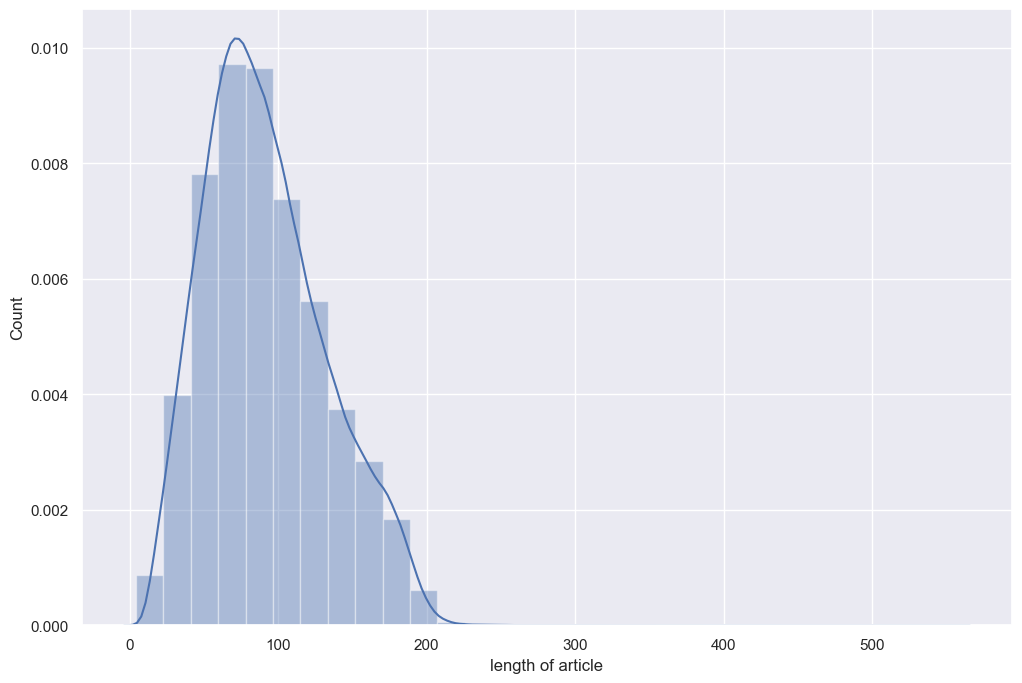

In [48]:
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.distplot(length, bins = 30, hist = True, kde = True)
ax.set(xlabel = "length of article", ylabel = "Count")
plt.show()

In [49]:
pd.Series(length).describe()

count    949875.000000
mean         91.763813
std          40.844877
min           4.000000
25%          61.000000
50%          86.000000
75%         118.000000
max         558.000000
dtype: float64

C:\Users\Nirajan\AppData\Local\Temp\ipykernel_15348\1073943355.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(word_count_list, bins = 30, hist = True, kde = True)


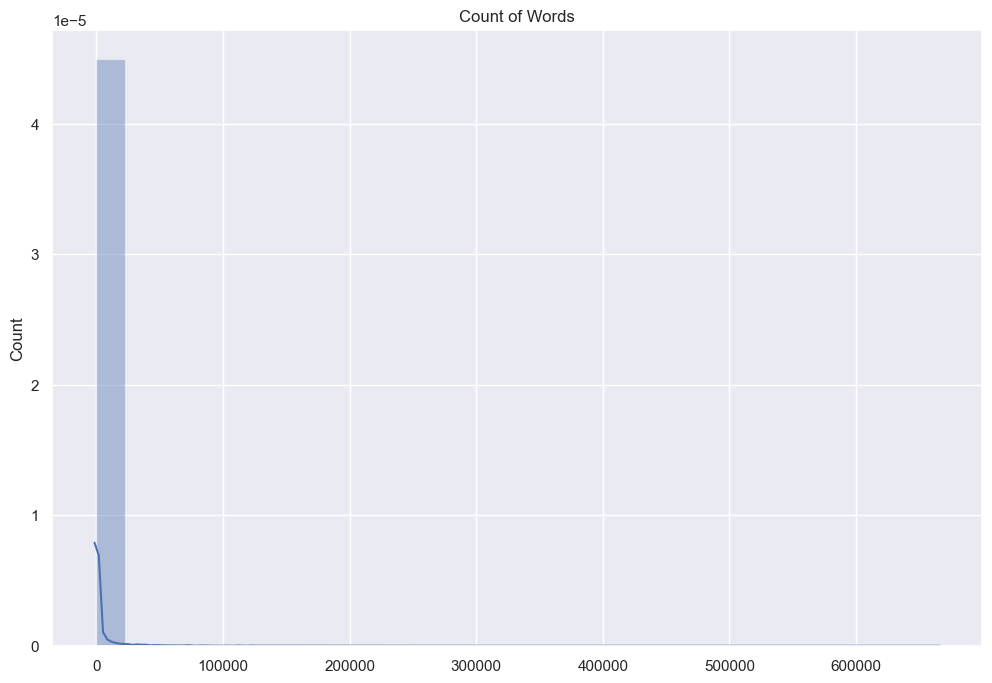

In [50]:
word_count_list = list(unique_word_dict.values())
ax = sns.distplot(word_count_list, bins = 30, hist = True, kde = True)
ax.set(ylabel = "Count", title = "Count of Words")
plt.show()

In [51]:
print(f"Total number of words in the text : {len(word_count_list)}")

Total number of words in the text : 227471


In [52]:
threshold_word_count = 50
len([i for i in word_count_list if i > threshold_word_count])

21638

In [53]:
UNIQUE_WORD_COUNT = 25_000
MAX_PAD_LENGTH = 210

## Tokenization

In [55]:
tokenizer = Tokenizer(num_words = UNIQUE_WORD_COUNT)
# tokenizer.fit_on_texts(X_train)

In [56]:
# saving the tokenizer
# with open('./models/tokenizer.pkl', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
with open('./models/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [60]:
%%time
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[0])
train_padded = pad_sequences(train_sequences, maxlen = MAX_PAD_LENGTH, padding = 'post', truncating = 'post')
print(train_padded[0])

[106, 2541, 4071, 168, 321, 526, 2614, 765, 20, 726, 338, 106, 292, 23, 4464, 22, 168, 441, 255, 246, 723, 1066, 862, 159, 30, 292, 306, 390, 3776, 1167, 1134, 390, 1167, 1167, 8846, 130, 66, 30, 3438, 275, 12, 1167, 504, 610, 862, 862, 159, 1192, 557, 144, 48, 28, 1597, 106, 1073, 535, 590, 150, 17, 3677, 2614, 125, 754, 401, 194, 3256, 17, 125, 224, 42, 4071, 246, 330, 20, 50, 723, 1066, 765, 42, 4071, 246, 229, 539, 467, 710, 330, 707, 62, 765, 6, 403, 459, 262, 54, 6884, 318, 374]
[ 106 2541 4071  168  321  526 2614  765   20  726  338  106  292   23
 4464   22  168  441  255  246  723 1066  862  159   30  292  306  390
 3776 1167 1134  390 1167 1167 8846  130   66   30 3438  275   12 1167
  504  610  862  862  159 1192  557  144   48   28 1597  106 1073  535
  590  150   17 3677 2614  125  754  401  194 3256   17  125  224   42
 4071  246  330   20   50  723 1066  765   42 4071  246  229  539  467
  710  330  707   62  765    6  403  459  262   54 6884  318  374    0
    0    0   

In [61]:
%%time
test_sequences = tokenizer.texts_to_sequences(X_test)
print(test_sequences[0])
test_padded = pad_sequences(test_sequences, maxlen = MAX_PAD_LENGTH, padding = "post", truncating = "post")
print(test_padded[0])

[580, 32, 220, 385, 61, 889, 385, 299, 126, 580, 32, 220, 385, 61, 7346, 528, 112, 385, 330, 564, 585, 889, 1284, 75, 19, 7346, 385, 500, 1284, 1446, 191, 128, 385, 233, 3349, 498, 1117, 1231, 7346, 272, 271, 1248, 157, 422, 914, 984, 332, 11, 126, 112, 7346, 19, 18105, 965, 2669, 499, 607, 371, 19, 598, 749, 59, 241, 170, 2327, 820, 122, 1284, 1446, 449, 8, 63, 92, 322, 1126, 1060, 183, 19, 253, 126, 112, 529, 749, 59, 1106, 49, 598, 749, 59, 241, 458, 1989, 185, 170, 888, 7346, 272, 271, 1248, 559, 32, 251, 7346, 621, 166, 1101, 261, 7346, 8]
[  580    32   220   385    61   889   385   299   126   580    32   220
   385    61  7346   528   112   385   330   564   585   889  1284    75
    19  7346   385   500  1284  1446   191   128   385   233  3349   498
  1117  1231  7346   272   271  1248   157   422   914   984   332    11
   126   112  7346    19 18105   965  2669   499   607   371    19   598
   749    59   241   170  2327   820   122  1284  1446   449     8    63
    92   32

## Model Development

In [62]:
y_train.head()

,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,cond-mat.mes-hall,cond-mat.mtrl-sci,...,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
N_CLASSES = 156

In [178]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config

In [179]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb,
        })
        return config

In [180]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
OUTPUT_DIM = N_CLASSES

## Mode Development
inputs = layers.Input(shape=(MAX_PAD_LENGTH,))
embedding_layer = TokenAndPositionEmbedding(MAX_PAD_LENGTH, UNIQUE_WORD_COUNT, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(OUTPUT_DIM, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [181]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [tf.keras.metrics.BinaryAccuracy(),
           tfa.metrics.HammingLoss(mode='multilabel'),
           ]
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

In [182]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 210)]             0         
                                                                 
 token_and_position_embeddin  (None, 210, 32)          806720    
 g_14 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_block_13 (Trans  (None, 210, 32)          10656     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_53 (Dropout)        (None, 32)                0  

In [183]:
history = model.fit(train_padded, y_train, batch_size=512, epochs = 5, validation_data=(test_padded, y_test))

Epoch 1/5
1856/1856 [==============================] - 1444s 777ms/step - loss: 0.0391 - binary_accuracy: 0.9896 - hamming_loss: 0.0115 - val_loss: 0.0225 - val_binary_accuracy: 0.9925 - val_hamming_loss: 0.0080
Epoch 2/5
1856/1856 [==============================] - 1454s 784ms/step - loss: 0.0222 - binary_accuracy: 0.9926 - hamming_loss: 0.0079 - val_loss: 0.0204 - val_binary_accuracy: 0.9930 - val_hamming_loss: 0.0075
Epoch 3/5
1856/1856 [==============================] - 1451s 782ms/step - loss: 0.0206 - binary_accuracy: 0.9930 - hamming_loss: 0.0075 - val_loss: 0.0197 - val_binary_accuracy: 0.9932 - val_hamming_loss: 0.0073
Epoch 4/5
1856/1856 [==============================] - 1452s 782ms/step - loss: 0.0198 - binary_accuracy: 0.9932 - hamming_loss: 0.0073 - val_loss: 0.0193 - val_binary_accuracy: 0.9933 - val_hamming_loss: 0.0072
Epoch 5/5
1856/1856 [==============================] - 1456s 784ms/step - loss: 0.0192 - binary_accuracy: 0.9933 - hamming_loss: 0.0072 - val_loss: 0.01

In [184]:
model_path = "./models/model2.h5"
model.save(model_path)

In [185]:
history_path = "./models/history2.history"
with open(history_path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Model Evaluation

In [186]:
history_path = "./models/history2.history"
with open(history_path, "rb") as file_pi:
    history = pickle.load(file_pi)

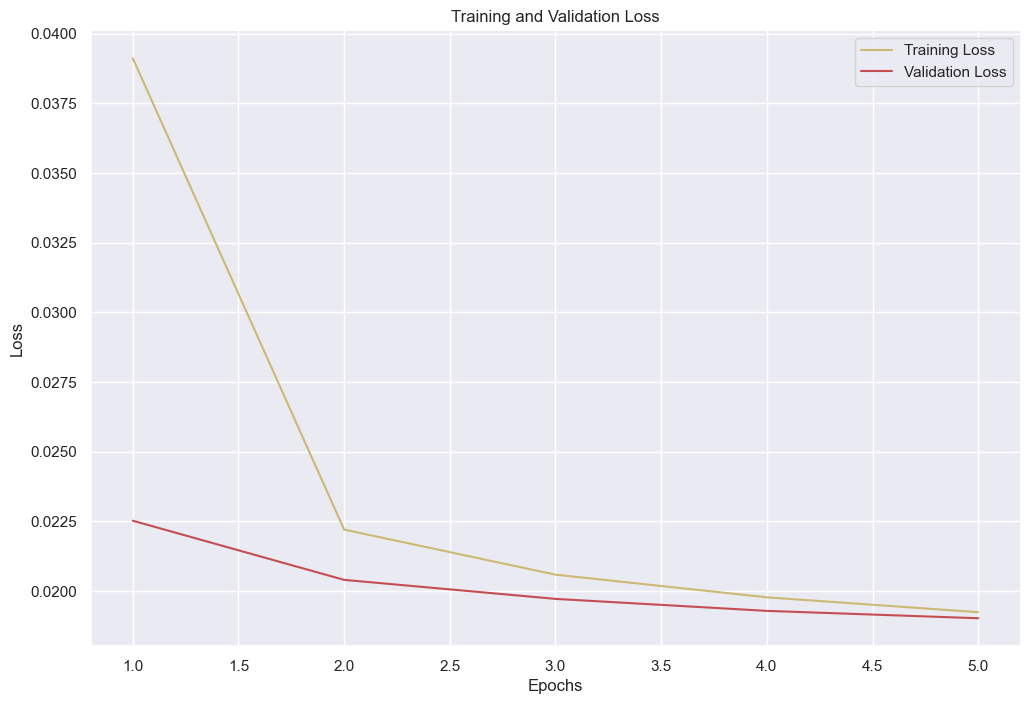

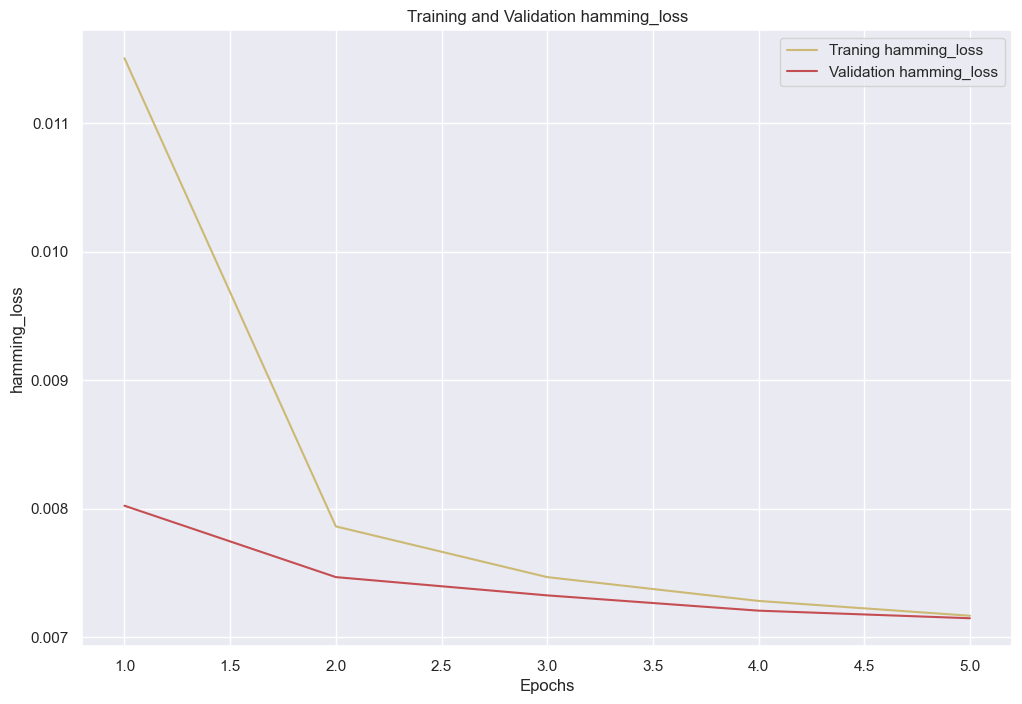

In [187]:
def historyVisualization(history):
    #plot the training and validation accuracy and losss at each epoch
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label="Training Loss")
    plt.plot(epochs, val_loss, 'r', label = "Validation Loss")
    plt.title('Training and Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print()

    acc = history['hamming_loss']
    val_acc = history['val_hamming_loss']
    plt.plot(epochs, acc, 'y', label = "Traning hamming_loss")
    plt.plot(epochs, val_acc, 'r', label = "Validation hamming_loss")
    plt.title("Training and Validation hamming_loss")
    plt.xlabel("Epochs")
    plt.ylabel("hamming_loss")
    plt.legend()
    plt.show()

    print()

historyVisualization(history)

## Prediction

In [188]:
test_data = pd.read_csv("./datasets/test_data.csv")

In [189]:
from keras.models import load_model

model_path = "./models/model2.h5"
custom_objects = {"TransformerBlock": TransformerBlock,
                  "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
                  "HammingLoss" : tfa.metrics.HammingLoss(mode='multilabel')}
loaded_model = load_model(model_path, custom_objects=custom_objects)

In [190]:
import nltk
import re
nltk.download("stopwords")
from nltk.stem import PorterStemmer
ps = PorterStemmer()

from nltk.corpus import stopwords
stop_word_collection = stopwords.words('english')

import string

def text_preprocess(text):
    # Remove all punctuations
    text = ''.join(c for c in text if c not in string.punctuation)

    # Remove all numbers and words containing numbers
    text = re.sub(r'\w*\d\w*', ' ', text).strip()

    # Changes to lower case
    text = text.lower()

    # Remove all stop words
    text = ' '. join(word for word in text.split() if word not in stop_word_collection)

    # Stemming of all words
    text = [ps.stem(word) for word in text.split()]
    text = ' '.join(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nirajan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [191]:
def predict(text, tokenizer, labels_list, preprocessed = False, top_k = 3):
    """
    Input:
    text: input text
    tokenizer: word tokenizer for the text
    labels_list: list of all the labels we have in our data
    preprocessed: Whether the input data is already processed or not
    top_k: no. of labels to be returned along with their probabililties

    Output:
    top_k no. of labels along with their corresponding probabilities
    """
    if not preprocessed:
        text = text_preprocess(text)
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen = MAX_PAD_LENGTH, padding = "post", truncating = "post")
    predictions = list(loaded_model.predict(text_padded)[0])
    # get the indices of top three values
    top_indices = [i for i, val in sorted(enumerate(predictions), key=lambda x: x[1], reverse=True)[:top_k]]
    # Create a new list with 1s for top three indices and 0s for the rest
    prediction_list = [1 if i in top_indices else 0 for i in range(len(predictions))]

    # For top k labels, the label name and their corresponding probabilities are provided
    labels = [labels_list[i] for i in range(len(labels_list)) if prediction_list[i] == 1]
    prediction_probabilities = [predictions[i] for i in range(len(predictions)) if prediction_list[i] == 1]
    sorted_data = sorted(zip(labels, prediction_probabilities), key=lambda x: x[1], reverse=True)

    return sorted_data

In [192]:
label_name = list(test_data.columns)
label_name.pop(0)
X_test, y_test = test_data["text"], test_data[label_name]

with open("./models/label_name.pkl", 'wb') as file_pi:
    pickle.dump(label_name, file_pi)

In [193]:
# Step 1: Load the labels list and the tokenizer
# Step 2: Predict the labels
with open('./models/label_name.pkl', 'rb') as handle:
    labels_list = pickle.load(handle)
with open('./models/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

text = X_test[0]
predict(text, tokenizer, labels_list = labels_list, preprocessed = True, top_k = 5)


1/1 [==============================] - 0s 289ms/step


[('hep-ph', 0.9811825),
 ('hep-ex', 0.286641),
 ('astro-ph.HE', 0.13871093),
 ('astro-ph.CO', 0.055689424),
 ('astro-ph', 0.0513921)]

In [194]:
text = """This study significantly concentrates on cryogenic InP HEMT high-frequency circuit analysis using quantum theory to find how the transistor nonlinearity can affect the quantum correlation of the modes generated. Firstly, the total Hamiltonian of the circuit is derived, and the dynamic equation of the motion contributed is examined using the Heisenberg-Langevin equation. Using the nonlinear Hamiltonian, some components are attached to the intrinsic internal circuit of InP HEMT to address the circuit characteristics fully. The components attached are arisen due to the nonlinearity effects. As a result, the theoretical calculations show that the states generated in the circuit are mixed, and no pure state is produced. Accordingly, the modified circuit generates the two-mode squeezed thermal state, which means one can focus on calculating the Gaussian quantum discord to evaluate quantum correlation. It is also found that the nonlinearity factors (addressed as the nonlinear components in the circuit) can intensely influence the squeezed thermal state by which the quantum discord is changed. Finally, as the primary point, it is concluded that although it is possible to enhance the quantum correlation between modes by engineering the nonlinear components; however, attaining quantum discord greater than unity, """
predict(text, tokenizer, labels_list = labels_list, preprocessed = False, top_k = 5)

1/1 [==============================] - 0s 30ms/step


[('quant-ph', 0.98361444),
 ('cond-mat.mes-hall', 0.12547077),
 ('physics.optics', 0.05880501),
 ('cond-mat.stat-mech', 0.02844336),
 ('cond-mat.other', 0.015106574)]

In [195]:
## Explanation steps of the prediction function
MAX_PAD_LENGTH = 210
text = "quantum physics is difficult."
text = text_preprocess(text)
print(text)
text_sequence = tokenizer.texts_to_sequences([text])
print(text_sequence)
text_padded = pad_sequences(text_sequence, maxlen = MAX_PAD_LENGTH, padding = "post", truncating = "post")
print(text_padded)
print("Prediction: ")
print(loaded_model.predict(text_padded))

quantum physic difficult
[[23, 136, 1291]]
[[  23  136 1291    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0